In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import math

In [ ]:
discussions_df = pd.read_csv('data/Discussions.csv', header=0, encoding='utf-8')
ratings_df = pd.read_csv('data/Ratings.csv', header=0, encoding='utf-8')
display(discussions_df)
display(ratings_df)

# Baseline Estimate

The most simple prediction system we can make is by using the baseline estimate: take the average rating of *every* user, and account for slight deviations in users and items.

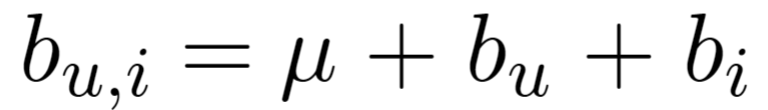

mu = Average rating of *every* item across *every* user\
b_u = Rating deviation of a given user u\
b_i = Rating deviation of a given item i

The idea is that if a user tends to rate more positively than the average user, we account for that in our rating deviation for that user. On a similar note, if an album tends to be more negatively rated than the average album, then we can account for that as well with our rating deviation for said album.

In [ ]:
# Standard mu + b_i + b_u
X = ratings_df.drop(columns=['Rating'])
y = ratings_df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train['Rating'] = y_train

mu = np.mean(X_train['Rating'])
y_pred = []
for idx, row in X_test.iterrows():
    b_u = np.mean(X_train[X_train['MemberID'] == row['MemberID']]['Rating']) - mu
    b_u = 0 if math.isnan(b_u) else b_u
    b_i = np.mean(X_train[X_train['DiscussionID'] == row['DiscussionID']]['Rating']) - mu
    b_i = 0 if math.isnan(b_i) else b_i
    estimate = max(min(int(np.round(mu - b_u - b_i)), 10), 1)
    y_pred.append(estimate)
y_pred = np.array(y_pred)
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print(rmse)

So what does the RMSE of 2.128 stand for? This effectively means that for any given album, our prediction will (on average) be off by about 2.128 units. 

However, that's not really good, considering how wide 2.128 actually is! There is definitely margin for improvement, and collaborative filtering is a step in the right direction.

# User-User Collaborative Filtering

The main principle behind user-user CF is that we can make better assessments of ratings by comparing to similar users. Think about it: although we can account for user deviations (if someone tends to rate more positively/negatively), it can only take us so far. With User-User CF, we can group users based on similarity.

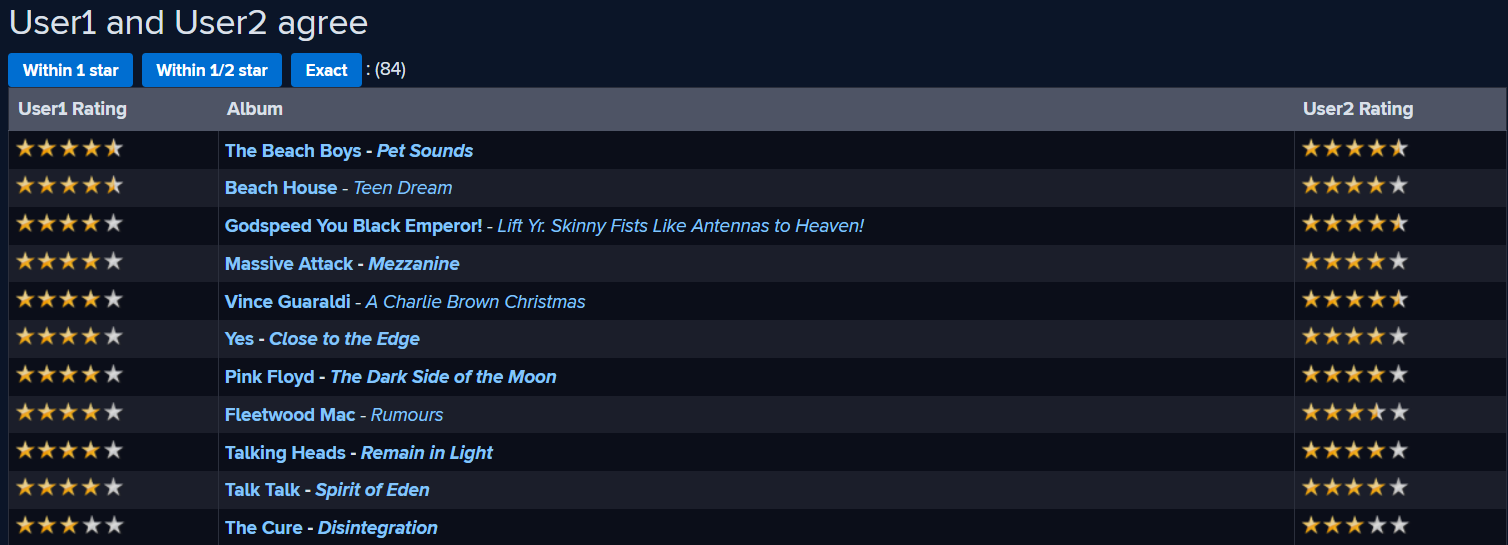

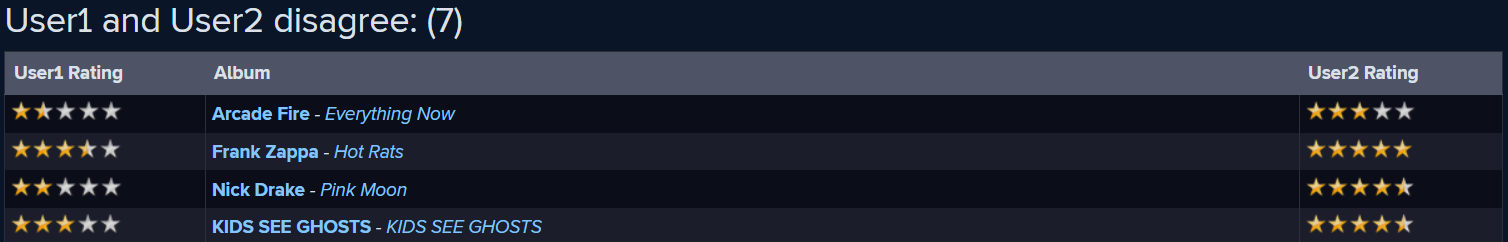

As an example, from the screenshots above, for two users User1 and User2, it can be seen that they hold a lot of similar opinions on albums. Based on this, when User1 rates an album, it is very likely that User2 will also have a similar rating (within 2 points (out of 10)), and vice versa.

In [ ]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    return dot_product / (norm_vec1 * norm_vec2)

def count_non_zeros(arr):
    return sum(1 for num in arr if num != 0)

In [ ]:
X = ratings_df.drop(columns=['Rating'])
y = ratings_df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train['Rating'] = y_train

pivot_df = X_train.pivot(index='DiscussionID', columns='MemberID', values='Rating')
pivot_df = pivot_df.fillna(0)
display(pivot_df)

In [ ]:
# Retrieve sample entry: MemberID=341's rating of DiscussionID=67
print(list(pivot_df[336]))

In [ ]:
user = 341
album = 68
user_sims = {}

for member_id in pivot_df.columns:
    if member_id != user:
        print('User:', member_id)
        print('Cosine Sim:', cosine_similarity(pivot_df[user], pivot_df[member_id]))
        user_sims[member_id] = cosine_similarity(pivot_df[user], pivot_df[member_id])

In [ ]:
rated_users = []
for i in pivot_df.columns:
    if pivot_df[i][album] != 0 and i != user:
        rated_users.append(i)
rated_user_sims = []
for u in rated_users:
    rated_user_sims.append(user_sims[u])
    
top3_rated_users = []
top3_sims = []
sorted_pairs = sorted(zip(rated_users, rated_user_sims), key=lambda x: x[1], reverse=True)
for top3_user, sim in sorted_pairs[:3]:
    print(top3_user, sim)
    top3_rated_users.append(top3_user)
    top3_sims.append(sim)
normalized_top3_sims = top3_sims / sum(top3_sims)

pred_r = 0
ind = 0
# # predict the rating with the weighted avg
for u in top3_rated_users:
    pred_r += normalized_top3_sims[ind] * pivot_df[u][68]
    ind += 1
print(f'User {user}\'s Predicted Rating of Album {album}: {pred_r}')

In [ ]:
y_pred = []

X = ratings_df.drop(columns=['Rating'])
y = ratings_df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train['Rating'] = y_train

pivot_df = X_train.pivot(index='DiscussionID', columns='MemberID', values='Rating')
pivot_df = pivot_df.fillna(0)

for idx, row in X_test.iterrows():
    user = row['MemberID']
    album = row['DiscussionID']
    user_sims = {}
    
    if user not in pivot_df.columns:
        y_pred.append(int(np.round(X_train['Rating'].mean(),0)))
        continue
    if album not in pivot_df.index:
        y_pred.append(int(np.round(X_train['Rating'].mean(),0)))
        continue

    for member_id in pivot_df.columns:
        if member_id != user:
            user_sims[member_id] = cosine_similarity(pivot_df[user], pivot_df[member_id])

    rated_users = []
    for i in pivot_df.columns:
        if pivot_df[i][album] != 0 and i != user:
            rated_users.append(i)
    rated_user_sims = []
    for u in rated_users:
        rated_user_sims.append(user_sims[u])

    top5_rated_users = []
    top5_sims = []
    sorted_pairs = sorted(zip(rated_users, rated_user_sims), key=lambda x: x[1], reverse=True)
    for top5_user, sim in sorted_pairs[:5]:
        top5_rated_users.append(top5_user)
        top5_sims.append(sim)
    normalized_top5_sims = top5_sims / sum(top5_sims)

    pred_r = 0
    ind = 0
    # # predict the rating with the weighted avg
    for u in top5_rated_users:
        pred_r += normalized_top5_sims[ind] * pivot_df[u][album]
        ind += 1

    y_pred.append(int(np.round(pred_r,0)))
    
y_pred = np.array(y_pred)
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print("RMSE:", rmse)

# Item-Item Collaborative Filtering

We also don't have to limit ourselves to just users! We can also think in the other dimension and analyze similarity between albums! If two albums have many ratings that are similar across, then we can make a good educated guess on what a user might think of an album if we already know one rating!

In [ ]:
# TODO: implement Item-Item CF
# Hint: can we repurpose much of the code from the user-user CF into here?